# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_regression
import plotly.graph_objects as go
from operator import itemgetter
import time
from xgboost import XGBRegressor
import typing
SEED = 17

# Ładowanie danych

In [2]:
data=pd.read_csv("../data/data_eda.csv")
data=data.drop(columns=['Unnamed: 0'])
features=data.columns.tolist()
features.remove('stars')
target='stars'
data

,pages,stars,reviews,series,mix,character,plot,funny,lighthearted,emotional,...,author_stars,Fiction,Nonfiction,Literary,Fantasy,Crime,Social,Children,Romans,Realism
0,273,4.00,2017,0,0.44,0.51,0.02,0.27,0.37,0.91,...,4.305000,1,1,0,0,0,1,0,1,1
1,302,3.78,7330,0,0.39,0.42,0.17,0.03,0.01,0.18,...,3.670000,1,0,0,0,1,0,0,0,0
2,400,4.15,16761,0,0.51,0.39,0.08,0.02,0.01,0.88,...,0.000000,1,0,1,0,0,0,0,0,0
3,459,4.16,2128,1,0.48,0.10,0.40,0.04,0.02,0.07,...,0.000000,1,0,0,1,0,0,0,0,0
4,160,3.65,6634,1,0.28,0.16,0.54,0.92,0.73,0.00,...,4.115000,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6925,432,4.15,30643,0,0.48,0.05,0.46,0.00,0.00,0.40,...,3.856667,1,0,0,1,1,0,0,0,0
6926,352,3.62,1058,0,0.55,0.13,0.30,0.15,0.10,0.25,...,3.700000,1,0,0,1,0,1,0,0,0
6927,535,3.88,30975,1,0.45,0.08,0.45,0.14,0.19,0.31,...,3.870000,1,0,0,1,0,0,1,0,0
6928,472,3.88,5914,1,0.64,0.12,0.22,0.07,0.00,0.36,...,3.660000,1,0,0,1,0,0,1,0,0


$\text{Podział danych na zbiór treningowy i testowy}$

In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

In [4]:
def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: typing.Any, cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: typing.Any = mean_squared_error) -> typing.List[float]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (typing.Any): algorithm to use for training and prediction
        cv (typing.Any): cross-validation strategy
        metric (typing.Any): metric to use for evaluation
    
    Returns:
        typing.List[float]: list of scores in order: train_scores, validation_scores
    """
    train_scores = []
    validation_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        train_scores.append(metric(y_train, y_train_pred, squared=False))
        validation_scores.append(metric(y_val, y_val_pred, squared=False))
    return np.mean(train_scores), np.mean(validation_scores)

def evaluation(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: typing.Any, metric: typing.Any = mean_squared_error) -> typing.Tuple[float, float, np.ndarray]:
    """
    Train the algorithm on the train data and evaluate on the train and test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (typing.Any): algorithm to use for training and prediction
        metric (typing.Any): metric to use for evaluation
    
    Returns:
        typing.Tuple[float, float, np.ndarray]: train_score, test_score, predictions on test data
    """
    algorithm.fit(X_train, y_train)
    y_train_pred = algorithm.predict(X_train)
    y_test_pred = algorithm.predict(X_test)
    train_results = metric(y_train, y_train_pred, squared=False)
    test_results = metric(y_test, y_test_pred, squared=False)
    return train_results, test_results, y_test_pred

## Model bez feature engineeringu

In [5]:
model = XGBRegressor(random_state=SEED, n_jobs=-1)
train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
print("Train RMSE:", train_scores)
print("Validation RMSE:", validation_scores)

Train RMSE: 0.06206850002022659
Validation RMSE: 0.19808813044143286


## Model z interakcjami

In [6]:
data_interactions=pd.read_csv("../data/data_interactions.csv")
data_interactions=data_interactions.drop(columns=['Unnamed: 0'])
features_interactions=data_interactions.columns.tolist()
features_interactions.remove('stars')
train_data_interactions, test_data_interactions = train_test_split(data_interactions, test_size=0.2, random_state=SEED)
model = XGBRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data_interactions[features_interactions], train_data_interactions[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 0.05078
Średni błąd RMSE na zbiorze walidacyjnym: 0.19741


## Model z transformacją zmiennych

In [7]:
data_transformations=pd.read_csv("../data/data_feature_engineering.csv")
data_transformations=data_transformations.drop(columns=['Unnamed: 0'])
features_transformations=data_transformations.columns.tolist()
features_transformations.remove('stars')
train_data_transformations, test_data_transformations = train_test_split(data_transformations, test_size=0.2, random_state=SEED)
model = XGBRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data_transformations[features_transformations], train_data_transformations[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 0.05205
Średni błąd RMSE na zbiorze walidacyjnym: 0.19940


Widzimy, że dla takiego silnego modelu najlepszy jest zbiór danych z interakcjami.

## Selekcja zmiennych

$\text{Warto zweryfikować również jak zmniejszenie liczby zmiennych wpłynie na wynik modelu.}$<p>
$\text{W tym celu wykorzystamy Mutual Information oraz kilka progów odcięcia.}$

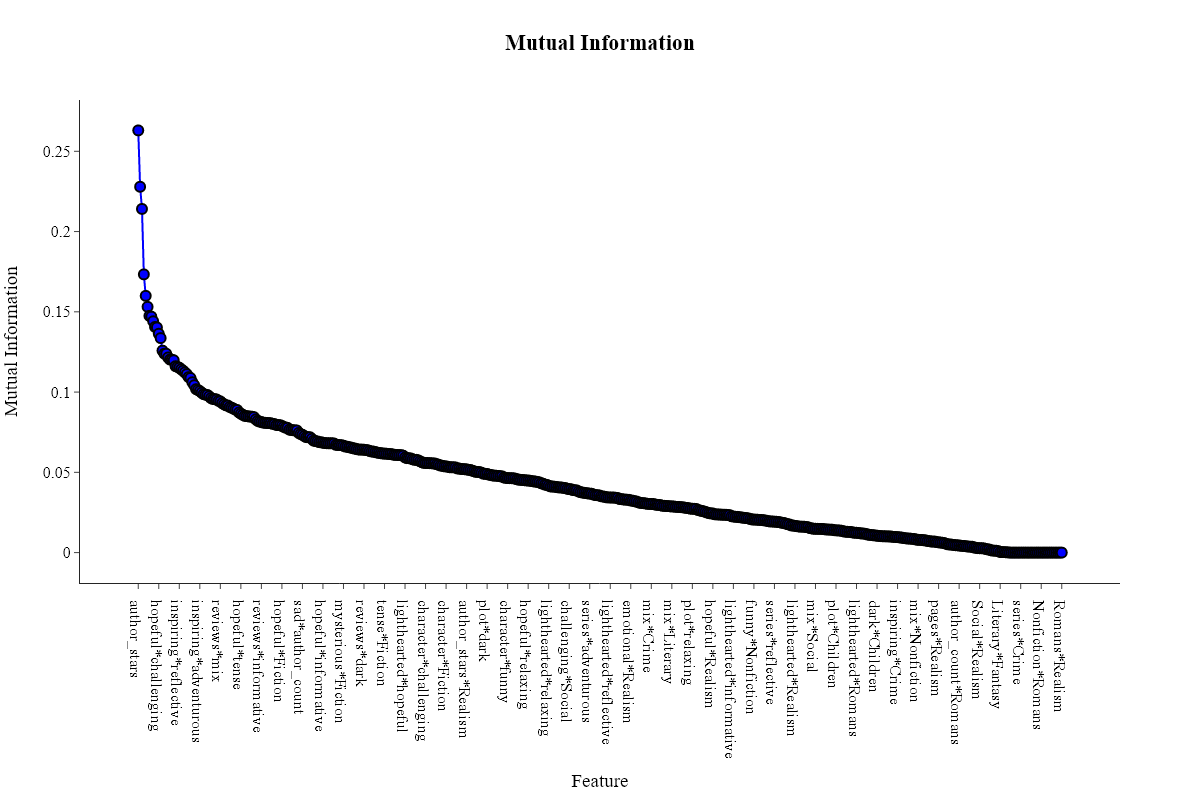

In [8]:
mi_scores = {feature: mutual_info_regression(train_data_interactions[[feature]], train_data_interactions[target], random_state=SEED)[0] for feature in features_interactions}
mi_scores = {k: v for k, v in sorted(mi_scores.items(), key=lambda item: item[1], reverse=True)}
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(mi_scores.keys()), y=list(mi_scores.values()), mode='lines+markers', marker=dict(size=10, color="blue", line=dict(width=2, color="black")), line=dict(width=2, color="blue")))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Mutual Information<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Mutual Information", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

$\text{Wybierzemy progi odcięcia na poziomie wybranych percentyli wartości MI i porównamy wyniki modeli.}$

In [9]:
for quantile in [0, 0.1, 0.25, 0.5, 0.75, 0.9]:
    threshold = np.quantile(list(mi_scores.values()), quantile)
    features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
    subset = set(features_interactions) - set(features_to_drop)
    model = XGBRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data_interactions[list(subset)], train_data_interactions[target], model)
    print("Kwantyl: {}; Procent zmiennych: {}%".format(1-quantile, np.round(len(subset)/len(features_interactions)*100, 2)))
    print(f"Średni błąd RMSE na zbiorze treningowym dla kwantyla {quantile}: {train_scores}")
    print(f"Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla {quantile}: {validation_scores}")
    print()

Kwantyl: 1; Procent zmiennych: 100.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0: 0.05077919223101292
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0: 0.19793006035865077

Kwantyl: 0.9; Procent zmiennych: 89.92%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.1: 0.049446277013015454
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.1: 0.19902771453859508

Kwantyl: 0.75; Procent zmiennych: 75.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.25: 0.05011837106634126
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.25: 0.19832170141718447

Kwantyl: 0.5; Procent zmiennych: 50.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.5: 0.049412216327864675
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.5: 0.19925579951523154

Kwantyl: 0.25; Procent zmiennych: 25.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.75: 0.055367137989317215
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.75: 0.20470537571833317

Kwantyl: 0

$\text{Zmniejszenie liczby zmiennych pogarsza wyniki modelu.}$<p>
$\text{Podobny eksperyment przeprowadzimy w sytuacji, gdy sugerujemy się istotnością zmiennych z modelu XGBoost.}$

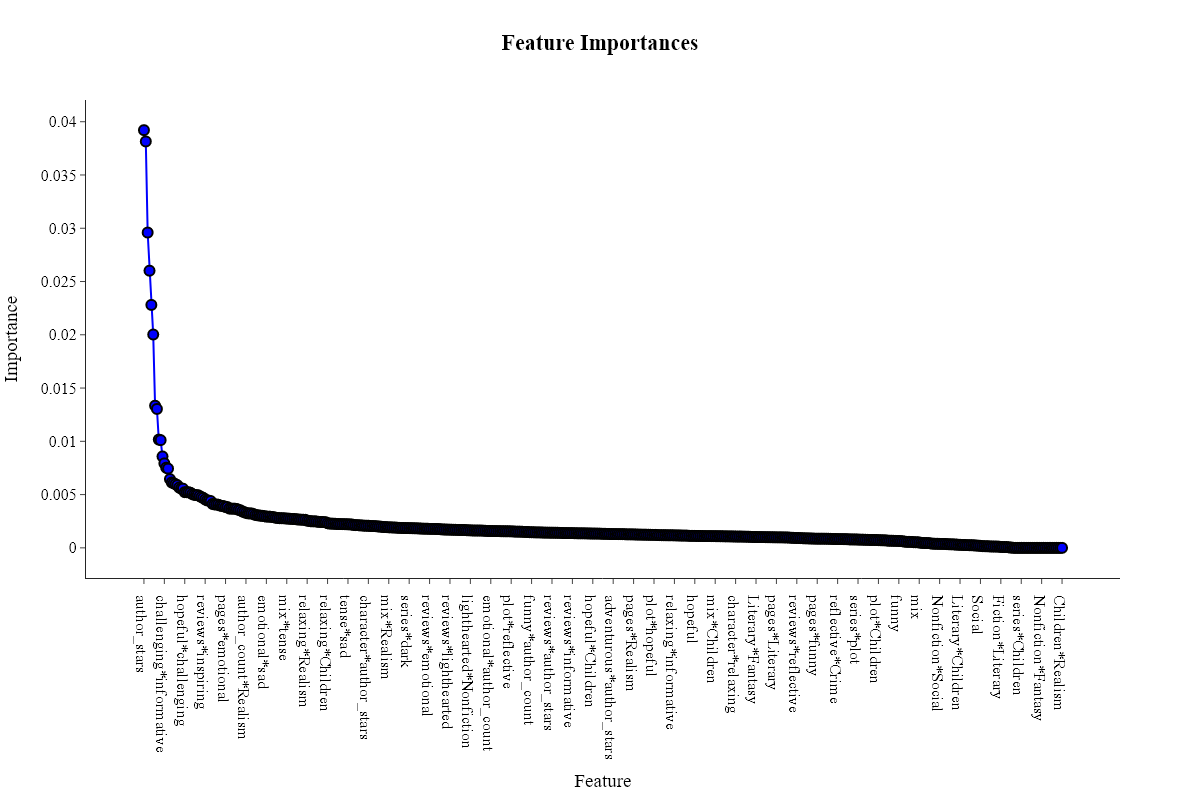

In [10]:
model = XGBRegressor(random_state=SEED)
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
feature_importances = np.zeros(len(features_interactions))
for train_idx, val_idx in kfold.split(train_data_interactions[features_interactions], train_data_interactions[target]):
    X_train, X_val = train_data_interactions[features_interactions].iloc[train_idx], train_data_interactions[features_interactions].iloc[val_idx]
    y_train, y_val = train_data_interactions[target].iloc[train_idx], train_data_interactions[target].iloc[val_idx]
    model.fit(X_train, y_train)
    feature_importances += model.feature_importances_
feature_importances /= kfold.n_splits
feature_importances = {feature: importance for feature, importance in zip(features_interactions, feature_importances)}
feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(feature_importances.keys()), y=list(feature_importances.values()), mode='lines+markers', marker=dict(size=10, color="blue", line=dict(width=2, color="black")), line=dict(width=2, color="blue")))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Feature Importances<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Importance", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

$\text{Ponownie zmienna author\_stars okazała się najbardziej istotna.}$

In [11]:
for quantile in [0, 0.1, 0.25, 0.5, 0.75, 0.9]:
    threshold = np.quantile(list(feature_importances.values()), quantile)
    features_to_drop = [k for k, v in feature_importances.items() if v < threshold]
    subset = set(features_interactions) - set(features_to_drop)
    model = XGBRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data_interactions[list(subset)], train_data_interactions[target], model)
    print("Kwantyl: {}; Procent zmiennych: {}%".format(1-quantile, np.round(len(subset)/len(features_interactions)*100, 2)))
    print(f"Średni błąd RMSE na zbiorze treningowym dla kwantyla {quantile}: {train_scores}")
    print(f"Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla {quantile}: {validation_scores}")
    print()

Kwantyl: 1; Procent zmiennych: 100.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0: 0.05077919223101292
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0: 0.19793006035865077

Kwantyl: 0.9; Procent zmiennych: 89.92%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.1: 0.05011380921184542
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.1: 0.198292670441517

Kwantyl: 0.75; Procent zmiennych: 75.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.25: 0.05166681070681336
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.25: 0.19604391614639724

Kwantyl: 0.5; Procent zmiennych: 50.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.5: 0.05398460204947307
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.5: 0.19771015329384561

Kwantyl: 0.25; Procent zmiennych: 25.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.75: 0.060859366873539635
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.75: 0.1974390670898689

Kwantyl: 0.0999

$\text{Widzimy, że w przypadku, gdy wybieramy około 75\% zmiennych, wyniki modelu są nieznacznie lepsze niż dla pełnego zbioru.}$<p>
$\text{Spróbujemy dokładniej zbadać w okolicach tego progu jaki threshold okaże się najbardziej optymalny.}$

In [12]:
for quantile in np.linspace(0.15, 0.35, 21):
    threshold = np.quantile(list(feature_importances.values()), quantile)
    features_to_drop = [k for k, v in feature_importances.items() if v < threshold]
    subset = set(features_interactions) - set(features_to_drop)
    model = XGBRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data_interactions[list(subset)], train_data_interactions[target], model)
    print("Kwantyl: {}; Procent zmiennych: {}%".format(1-quantile, np.round(len(subset)/len(features_interactions)*100, 2)))
    print(f"Średni błąd RMSE na zbiorze treningowym dla kwantyla {quantile}: {train_scores}")
    print(f"Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla {quantile}: {validation_scores}")
    print()

Kwantyl: 0.85; Procent zmiennych: 84.88%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.15: 0.04900780856648655
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.15: 0.19828494215769776

Kwantyl: 0.84; Procent zmiennych: 83.87%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.16: 0.04955719557415304
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.16: 0.1992810889041495

Kwantyl: 0.8300000000000001; Procent zmiennych: 82.86%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.16999999999999998: 0.05009612903538391
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.16999999999999998: 0.19830663099740672

Kwantyl: 0.8200000000000001; Procent zmiennych: 81.85%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.18: 0.050424238680961464
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.18: 0.19989743751728556

Kwantyl: 0.81; Procent zmiennych: 80.85%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.19: 0.05085797457739105
Średni błąd RMSE n

$\text{Wygląda na to, że kwantyl 0.25 jest optymalny.}$<p>
$\text{Usuniemy ze zbioru treningowego zmienne, które mają feature importance poniżej tego progu.}$

In [13]:
quantile = 0.25
threshold = np.quantile(list(feature_importances.values()), quantile)
features_to_drop = [k for k, v in feature_importances.items() if v < threshold]
subset = list(set(features_interactions) - set(features_to_drop))
model = XGBRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
print("Procent zmiennych: {}%".format(np.round(len(subset)/len(features_interactions)*100, 2)))
print(f"Średni błąd RMSE na zbiorze treningowym: {train_scores}")
print(f"Średni błąd RMSE na zbiorze walidacyjnym: {validation_scores}")
print()

Procent zmiennych: 75.0%
Średni błąd RMSE na zbiorze treningowym: 0.05166681070681336
Średni błąd RMSE na zbiorze walidacyjnym: 0.19604391614639724



# Tuning hiperparametrów XGBoost

1. Głębokość drzewa

In [14]:
for max_depth in range(2, 10):
    model = XGBRegressor(max_depth=max_depth, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Max depth: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(max_depth, train_scores, validation_scores))

Max depth: 2; RMSE train: 0.16861; RMSE validation: 0.19710
Max depth: 3; RMSE train: 0.13943; RMSE validation: 0.19363
Max depth: 4; RMSE train: 0.10891; RMSE validation: 0.19669
Max depth: 5; RMSE train: 0.07777; RMSE validation: 0.19551
Max depth: 6; RMSE train: 0.05167; RMSE validation: 0.19604
Max depth: 7; RMSE train: 0.03061; RMSE validation: 0.20024
Max depth: 8; RMSE train: 0.01580; RMSE validation: 0.20277
Max depth: 9; RMSE train: 0.00801; RMSE validation: 0.20537


Najlepszy wynik dla głębokości drzewa równej 3.

2. Subsample - udział wierszy w każdym drzewie

In [17]:
for subsample in np.linspace(0.1, 1, 10):
    model = XGBRegressor(max_depth=3, subsample=subsample, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Subsample: {:.1f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(subsample, train_scores, validation_scores))

Subsample: 0.1; RMSE train: 0.20046; RMSE validation: 0.24958
Subsample: 0.2; RMSE train: 0.16701; RMSE validation: 0.21869
Subsample: 0.3; RMSE train: 0.15331; RMSE validation: 0.20871
Subsample: 0.4; RMSE train: 0.14793; RMSE validation: 0.20062
Subsample: 0.5; RMSE train: 0.14254; RMSE validation: 0.20126
Subsample: 0.6; RMSE train: 0.14145; RMSE validation: 0.19736
Subsample: 0.7; RMSE train: 0.13946; RMSE validation: 0.19582
Subsample: 0.8; RMSE train: 0.13864; RMSE validation: 0.19312
Subsample: 0.9; RMSE train: 0.13895; RMSE validation: 0.19468
Subsample: 1.0; RMSE train: 0.13943; RMSE validation: 0.19363


Najlepszy wynik w sytuacji, gdy 80\% wierszy jest wykorzystywanych w każdym drzewie.

Możemy dokładniej zbadać w okolicach tego progu jaki udział wierszy okaże się najbardziej optymalny.

In [18]:
for subsample in np.linspace(0.75, 0.85, 11):
    model = XGBRegressor(max_depth=3, subsample=subsample, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Subsample: {:.2f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(subsample, train_scores, validation_scores))

Subsample: 0.75; RMSE train: 0.13789; RMSE validation: 0.19571
Subsample: 0.76; RMSE train: 0.13826; RMSE validation: 0.19386
Subsample: 0.77; RMSE train: 0.13834; RMSE validation: 0.19493
Subsample: 0.78; RMSE train: 0.13869; RMSE validation: 0.19503
Subsample: 0.79; RMSE train: 0.13819; RMSE validation: 0.19476
Subsample: 0.80; RMSE train: 0.13864; RMSE validation: 0.19312
Subsample: 0.81; RMSE train: 0.13801; RMSE validation: 0.19439
Subsample: 0.82; RMSE train: 0.13736; RMSE validation: 0.19443
Subsample: 0.83; RMSE train: 0.13908; RMSE validation: 0.19503
Subsample: 0.84; RMSE train: 0.13899; RMSE validation: 0.19494
Subsample: 0.85; RMSE train: 0.13872; RMSE validation: 0.19480


3. colsample_bytree - udział kolumn w każdym drzewie

In [19]:
for colsample_bytree in np.linspace(0.1, 1, 10):
    model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=colsample_bytree, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Colsample by tree: {:.1f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(colsample_bytree, train_scores, validation_scores))

Colsample by tree: 0.1; RMSE train: 0.14990; RMSE validation: 0.19790
Colsample by tree: 0.2; RMSE train: 0.14504; RMSE validation: 0.19402
Colsample by tree: 0.3; RMSE train: 0.14349; RMSE validation: 0.19622
Colsample by tree: 0.4; RMSE train: 0.14285; RMSE validation: 0.19507
Colsample by tree: 0.5; RMSE train: 0.14095; RMSE validation: 0.19497
Colsample by tree: 0.6; RMSE train: 0.13987; RMSE validation: 0.19419
Colsample by tree: 0.7; RMSE train: 0.13919; RMSE validation: 0.19278
Colsample by tree: 0.8; RMSE train: 0.13921; RMSE validation: 0.19498
Colsample by tree: 0.9; RMSE train: 0.13861; RMSE validation: 0.19482
Colsample by tree: 1.0; RMSE train: 0.13864; RMSE validation: 0.19312


Rezultaty sugerują, że procent kolumn w każdym drzewie powinien wynosić 70%.

4. colsample_bylevel - udział kolumn w każdym poziomie drzewa

In [20]:
for colsample_bylevel in np.linspace(0.1, 1, 10):
    model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=colsample_bylevel, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Colsample by level: {:.1f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(colsample_bylevel, train_scores, validation_scores))

Colsample by level: 0.1; RMSE train: 0.15034; RMSE validation: 0.19513
Colsample by level: 0.2; RMSE train: 0.14618; RMSE validation: 0.19472
Colsample by level: 0.3; RMSE train: 0.14457; RMSE validation: 0.19539
Colsample by level: 0.4; RMSE train: 0.14364; RMSE validation: 0.19511
Colsample by level: 0.5; RMSE train: 0.14237; RMSE validation: 0.19514
Colsample by level: 0.6; RMSE train: 0.14162; RMSE validation: 0.19565
Colsample by level: 0.7; RMSE train: 0.14060; RMSE validation: 0.19397
Colsample by level: 0.8; RMSE train: 0.14116; RMSE validation: 0.19363
Colsample by level: 0.9; RMSE train: 0.14024; RMSE validation: 0.19404
Colsample by level: 1.0; RMSE train: 0.13919; RMSE validation: 0.19278


Najlepszy wynik dla 100% kolumn w każdym poziomie drzewa.

Widzimy, że jednak nadal wynik na zbiorze treningowym znacząco lepszy niż testowym, więc dostosujemy parametry regularyzacji.

# Regularyzacja

Tutaj poszukamy parametru lambda (regularyzacja L2).

In [21]:
for lambda_ in [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15, 30, 50, 100]:
    model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=1, reg_lambda=lambda_, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Lambda: {:.2f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(lambda_, train_scores, validation_scores))

Lambda: 0.01; RMSE train: 0.13812; RMSE validation: 0.19612
Lambda: 0.10; RMSE train: 0.13832; RMSE validation: 0.19705
Lambda: 0.50; RMSE train: 0.13913; RMSE validation: 0.19497
Lambda: 1.00; RMSE train: 0.13919; RMSE validation: 0.19278
Lambda: 2.00; RMSE train: 0.14063; RMSE validation: 0.19515
Lambda: 4.00; RMSE train: 0.14239; RMSE validation: 0.19444
Lambda: 6.00; RMSE train: 0.14311; RMSE validation: 0.19438
Lambda: 8.00; RMSE train: 0.14383; RMSE validation: 0.19326
Lambda: 10.00; RMSE train: 0.14525; RMSE validation: 0.19489
Lambda: 15.00; RMSE train: 0.14658; RMSE validation: 0.19362
Lambda: 30.00; RMSE train: 0.14943; RMSE validation: 0.19423
Lambda: 50.00; RMSE train: 0.15285; RMSE validation: 0.19605
Lambda: 100.00; RMSE train: 0.15764; RMSE validation: 0.19680


Wraz ze wzrostem wartości lambda, wynik na zbiorze treningowym ulegają pogorszeniu.

Najlepszy wynik dla zbioru walidacyjnego otrzymano dla wartości lambda równej 1.

Możemy dokładniej sprawdzić wyniki dla wartości lambda z przedziału [0.5, 2].

In [22]:
for lambda_ in np.linspace(0.5, 2, 16):
    model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=1, reg_lambda=lambda_, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data_interactions[subset], train_data_interactions[target], model)
    print("Lambda: {:.2f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(lambda_, train_scores, validation_scores))

Lambda: 0.50; RMSE train: 0.13913; RMSE validation: 0.19497
Lambda: 0.60; RMSE train: 0.13996; RMSE validation: 0.19606
Lambda: 0.70; RMSE train: 0.13970; RMSE validation: 0.19581
Lambda: 0.80; RMSE train: 0.13994; RMSE validation: 0.19452
Lambda: 0.90; RMSE train: 0.13967; RMSE validation: 0.19397
Lambda: 1.00; RMSE train: 0.13919; RMSE validation: 0.19278
Lambda: 1.10; RMSE train: 0.13947; RMSE validation: 0.19298
Lambda: 1.20; RMSE train: 0.13981; RMSE validation: 0.19409
Lambda: 1.30; RMSE train: 0.13950; RMSE validation: 0.19566
Lambda: 1.40; RMSE train: 0.13974; RMSE validation: 0.19583
Lambda: 1.50; RMSE train: 0.14006; RMSE validation: 0.19429
Lambda: 1.60; RMSE train: 0.14053; RMSE validation: 0.19504
Lambda: 1.70; RMSE train: 0.14034; RMSE validation: 0.19373
Lambda: 1.80; RMSE train: 0.13972; RMSE validation: 0.19568
Lambda: 1.90; RMSE train: 0.14095; RMSE validation: 0.19493
Lambda: 2.00; RMSE train: 0.14063; RMSE validation: 0.19515


Najlepsze wyniki dla lambda równego 1.

Gamma to kolejny parametr regularyzacji, który określa minimalną redukcję strat wymaganą do utworzenia nowego liścia.

In [23]:
for gamma in [0, 0.01, 0.1, 0.5, 1, 2, 5]:
    model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=1, reg_lambda=1, gamma=gamma, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Gamma: {:.2f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(gamma, train_scores, validation_scores))

Gamma: 0.00; RMSE train: 0.15581; RMSE validation: 0.19333
Gamma: 0.01; RMSE train: 0.15593; RMSE validation: 0.19342
Gamma: 0.10; RMSE train: 0.15641; RMSE validation: 0.19312
Gamma: 0.50; RMSE train: 0.18384; RMSE validation: 0.20158
Gamma: 1.00; RMSE train: 0.20248; RMSE validation: 0.21108
Gamma: 2.00; RMSE train: 0.21534; RMSE validation: 0.21992
Gamma: 5.00; RMSE train: 0.23194; RMSE validation: 0.23518


Jak jednak widać, wzrost parametru gamma prowadzi do znacznych spadków wyników dla zbioru treningowego.

Warto jednak zauważyć, że w okolicach gamma równego 0.1 wyniki dla zbioru walidacyjnego są lepsze niż dla gamma równego 0.

Spróbujemy zbadać okolicę gamma równego 0.1 w celu znalezienia optymalnej wartości.

In [24]:
for gamma in np.linspace(0.01, 0.3, 30):
    model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=1, reg_lambda=1, gamma=gamma, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
    print("Gamma: {:.2f}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(gamma, train_scores, validation_scores))

Gamma: 0.01; RMSE train: 0.15593; RMSE validation: 0.19342
Gamma: 0.02; RMSE train: 0.15596; RMSE validation: 0.19357
Gamma: 0.03; RMSE train: 0.15603; RMSE validation: 0.19363
Gamma: 0.04; RMSE train: 0.15595; RMSE validation: 0.19308
Gamma: 0.05; RMSE train: 0.15587; RMSE validation: 0.19280
Gamma: 0.06; RMSE train: 0.15556; RMSE validation: 0.19258
Gamma: 0.07; RMSE train: 0.15620; RMSE validation: 0.19235
Gamma: 0.08; RMSE train: 0.15605; RMSE validation: 0.19267
Gamma: 0.09; RMSE train: 0.15628; RMSE validation: 0.19313
Gamma: 0.10; RMSE train: 0.15641; RMSE validation: 0.19312
Gamma: 0.11; RMSE train: 0.15674; RMSE validation: 0.19307
Gamma: 0.12; RMSE train: 0.15715; RMSE validation: 0.19364
Gamma: 0.13; RMSE train: 0.15805; RMSE validation: 0.19284
Gamma: 0.14; RMSE train: 0.15781; RMSE validation: 0.19334
Gamma: 0.15; RMSE train: 0.15904; RMSE validation: 0.19302
Gamma: 0.16; RMSE train: 0.15969; RMSE validation: 0.19246
Gamma: 0.17; RMSE train: 0.16035; RMSE validation: 0.194

$\text{Gamma wynoszące 0.07 wydaje się być optymalne.}$

## Zapisanie modelu

In [25]:
#Model bazowy
model = XGBRegressor(random_state=SEED)
base_train_scores, base_validation_scores = perform_cv(train_data_interactions[features_interactions], train_data_interactions[target], model)
train_results, base_test_score, y_test_pred = evaluation(train_data_interactions[features_interactions], train_data_interactions[target], test_data_interactions[features_interactions], test_data_interactions[target], model)
#Tuning
model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=1, reg_lambda=1, gamma=0.07, random_state=SEED, n_jobs=-1)
tuning_train_scores, tuning_validation_scores = perform_cv(train_data_interactions[features_interactions], train_data_interactions[target], model)
train_results, tuning_test_score, y_test_pred = evaluation(train_data_interactions[subset], train_data_interactions[target], test_data_interactions[subset], test_data_interactions[target], model)
results = pd.DataFrame({
    "Model": ["Base", "Tuning"],
    "Train RMSE": [base_train_scores, tuning_train_scores],
    "Validation RMSE": [base_validation_scores, tuning_validation_scores],
    "Test RMSE": [base_test_score, tuning_test_score]
})
results.style.background_gradient(cmap='Reds', axis=0)

,Model,Train RMSE,Validation RMSE,Test RMSE
0,Base,0.050779,0.197413,0.201657
1,Tuning,0.139939,0.194428,0.196656


In [26]:
test_indices = test_data.index
#Ewaluacja modelu
model = XGBRegressor(max_depth=3, subsample=0.8, colsample_bytree=0.7, colsample_bylevel=1, reg_lambda=1, gamma=0.07, random_state=SEED, n_jobs=-1)
train_results, test_results, y_test_pred = evaluation(train_data_interactions[subset], train_data_interactions[target], test_data_interactions[subset], test_data_interactions[target], model)
print("Train RMSE: {}".format(round(train_results, 5)))
print("Test RMSE: {}".format(round(test_results, 5)))

#Zapisanie modelu
model_XGB = {
    "name": "XGB",
    "trainResults": train_results,
    "testResults": test_results,
    "predictions": y_test_pred,
    "indices": test_indices,
}
with open("../data/model_XGB.p", "wb") as fp:
    pickle.dump(model_XGB, fp)

Train RMSE: 0.14595
Test RMSE: 0.19666


## Podsumowanie

$\text{Najlepsze wyniki walidacji krzyżowej uzyskano dla modelu bazującego na interakcjach zmiennych bez transformacji.}$<p>
$\text{Optymalizacja hiperparametrów oraz regularyzacja pozwoliły na poprawę wyników.}$<p>
$\text{Wyniki na zbiorze treningowym (RMSE): 0.14658}$<p>
$\text{Wyniki na zbiorze testowym (RMSE): 0.19666}$